# Evaluate impact of kernel activation and initialization

### 1. Generate random training data

Populating the interactive namespace from numpy and matplotlib
0.47
(1000, 100)
(1000,)


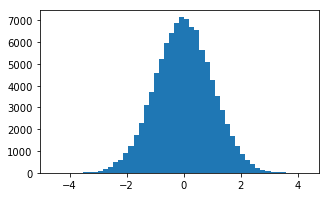

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%pylab inline
%matplotlib inline
pylab.rcParams['figure.figsize'] = (5, 3)

# Create random train data
X_train = np.random.normal(size=(1000, 100))
Y_train = (X_train.sum(axis=1) > 0) * 1

print Y_train.mean()
print X_train.shape
print Y_train.shape

# Normalize it
X_train -= X_train.mean()
X_train /= X_train.std()

plt.hist(X_train.reshape(-1), 50)
plt.show()

### 2. Build a simple fully connected model 

In [2]:
import keras
import keras.backend as K
from keras.layers import Input, Dense, multiply, Lambda
from keras.models import Model
from keras.activations import tanh_perso, sig_perso
from keras.initializers import VarianceScaling
import shutil
import time
import os


def _func_to_str(func):
    """if func is a function, returns its string name"""
    return func.func_name if callable(func) else str(func)


def simple_FC_model(activation, initializer):
    # Define input tensor
    input_tensor = Input(shape=(100,))
    if callable(initializer) is True:
        initializer = initializer()
    
    # Propagate it through 20 fully connected layers
    x = Dense(256,
              activation=activation,
              kernel_initializer=initializer)(input_tensor)
    for _ in range(19):
        x = Dense(256,
                  activation=activation,
                  kernel_initializer=initializer)(x)
    
    x = Dense(1,
              activation='sigmoid',
              kernel_initializer='lecun_normal')(x)
    
    # Build the keras model    
    model = Model(input_tensor, x, name='')
    sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd, loss='binary_crossentropy')

    return model


def show_model(activations, initializers, func_model=None):
    """Shows prediction distribution for each pair of activation/initializer
    
    Params:
        activations: a list of activations
        initializers: a list of initializers (same lenght as activations)
    """
    start = time.time()
    n_fig = len(activations)
    is_gated = False if func_model is None else True

    fig, axs = plt.subplots(2, n_fig)
    for i in range(n_fig):
        act, init = zip(activations, initializers)[i]
        
        # Parameters to Strings
        act_str = _func_to_str(act)
        if is_gated is True:
            act_str = 'gated_' + act_str
        init_str = _func_to_str(init)
        
        # Build the model and evaluate it
        K.clear_session()
        func_model = func_model or simple_FC_model
        model = func_model(act, init)
        get_activations = K.function([model.layers[0].input, K.learning_phase()],
                                     [model.layers[-2].output] )
        act_hist = get_activations([X_train, False])[0]
        
        # Show the 1st results
        axs[0, i].hist(act_hist.reshape(-1), 50)
        axs[0, i].set_title(act_str + " - " + init_str)
        
        # Show the 2nd results
        log_dir = './logs/' + act_str + '-' + init_str
        if os.path.isdir(log_dir):
            shutil.rmtree(log_dir)
        tensorboard = keras.callbacks.TensorBoard(histogram_freq=1,
                                                  log_dir=log_dir,
                                                  write_grads=True)
        model.fit(X_train,
                  Y_train,
                  validation_data=(X_train, Y_train),
                  epochs=10,
                  batch_size=128,
                  verbose=False,
                  callbacks=[tensorboard, ])
        pred2 = model.predict(X_train)
        act_hist2 = get_activations([X_train, False])[0]
        axs[1, i].hist(act_hist2.reshape(-1), 50)
                
        # Write some debug
        print "{} {} std: {:.4f}, mean: {:.3f}, acc: {}".format(
            act_str,
            init_str,
            act_hist.std(),
            act_hist.mean(),
            (pred2.round().T == Y_train).mean())
        
        K.clear_session()

    end = time.time()
    forward_pass_time = (end - start) / n_fig
    print "\nTook and average of {:.3} sec. to perfom training".format(forward_pass_time)
    plt.show()


Using TensorFlow backend.


### 3. Weights initialization

http://yann.lecun.com/exdb/publis/pdf/lecun-98b.pdf  
http://jmlr.org/proceedings/papers/v9/glorot10a/glorot10a.pdf

- Normal: draws weights from a normal distribution with $\mu=0$ and $\sigma = 1$

- Glorot normal initializer: draws weights from truncated normal with $\mu=0$ and
$\sigma = \sqrt\frac{2}{\text{fan_in} + \text{fan_out}}$

- Lecun normal initializer: draws weights from truncated normal with $\mu=0$ and
$\sigma = \sqrt\frac{1}{\text{fan_in}}$

--- 
- Uniform: draws weights from a uniform distribution with $f : \mathbb{R} \to [-x_{max}; x_{max}]$ and $x_{max} = 0.05$

- Glorot uniform initializer: draws weights Uniform distribution with
$x_{max} = \sqrt\frac{6}{\text{fan_in} + \text{fan_out}}$

- Lecun Uniform initializer: draws weights Uniform distribution with
$x_{max} = \sqrt\frac{3}{\text{fan_in}}$



###  4. Show activation distributions
##### a) Relu

relu uniform std: 0.0000, mean: 0.000, acc: 0.53
relu glorot_uniform std: 0.0006, mean: 0.000, acc: 0.53
relu normal std: 0.0000, mean: 0.000, acc: 0.53
relu glorot_normal std: 0.0001, mean: 0.000, acc: 0.53

Took and average of 15.5 sec. to perfom training


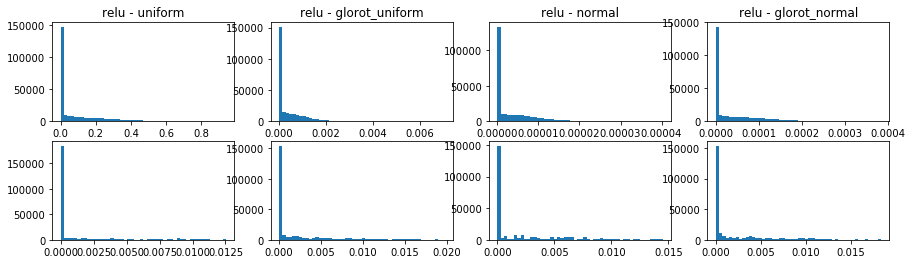

In [3]:
pylab.rcParams['figure.figsize'] = (15, 4)
activations = ['relu']*4
initializers = ['uniform', 'glorot_uniform', 'normal', 'glorot_normal']
show_model(activations, initializers)

##### b) Sigmoid

sigmoid uniform std: 0.0530, mean: 0.499, acc: 0.53
sigmoid glorot_uniform std: 0.1291, mean: 0.503, acc: 0.53
sigmoid lecun_uniform std: 0.1263, mean: 0.493, acc: 0.53
sigmoid normal std: 0.0902, mean: 0.494, acc: 0.53
sigmoid glorot_normal std: 0.1053, mean: 0.501, acc: 0.53
sigmoid lecun_normal std: 0.1103, mean: 0.506, acc: 0.53

Took and average of 15.3 sec. to perfom training


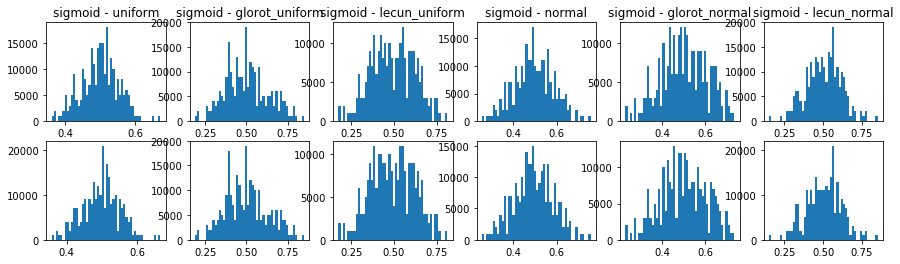

In [4]:
pylab.rcParams['figure.figsize'] = (15, 4)
activations = ['sigmoid']*6
initializers = ['uniform', 'glorot_uniform', 'lecun_uniform', 'normal', 'glorot_normal', 'lecun_normal']
show_model(activations, initializers)

##### c) tanh

tanh uniform std: 0.0000, mean: 0.000, acc: 0.53
tanh glorot_uniform std: 0.1632, mean: -0.000, acc: 0.997
tanh normal std: 0.0048, mean: 0.000, acc: 0.53
tanh glorot_normal std: 0.0279, mean: 0.000, acc: 0.977

Took and average of 16.4 sec. to perfom training


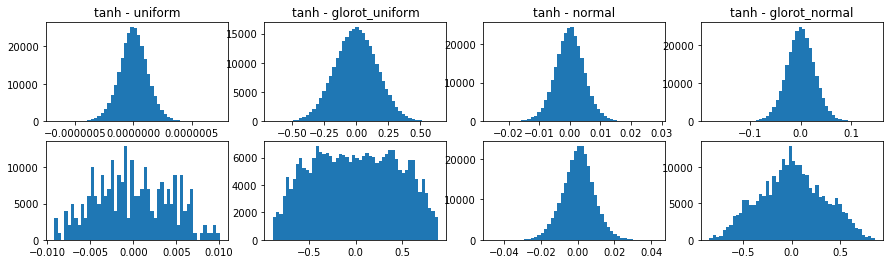

In [5]:
pylab.rcParams['figure.figsize'] = (15, 4)
activations = ['tanh']*4
initializers = ['uniform', 'glorot_uniform', 'normal', 'glorot_normal']
show_model(activations, initializers)

##### c) Lecun tanh

lecun_tanh uniform std: 0.0000, mean: 0.000, acc: 0.53
lecun_tanh glorot_uniform std: 0.6100, mean: -0.001, acc: 0.999
lecun_tanh lecun_uniform std: 0.6243, mean: -0.000, acc: 1.0
lecun_tanh normal std: 0.0643, mean: -0.000, acc: 0.972
lecun_tanh glorot_normal std: 0.2741, mean: 0.001, acc: 1.0
lecun_tanh lecun_normal std: 0.2779, mean: -0.000, acc: 0.997

Took and average of 25.2 sec. to perfom training


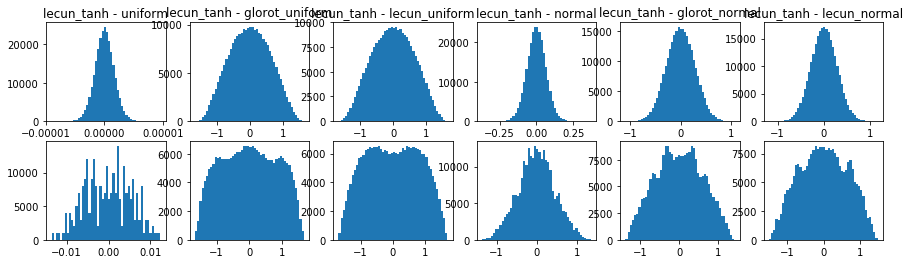

In [6]:
pylab.rcParams['figure.figsize'] = (15, 4)

def lecun_tanh(x):
    return 1.7159 * K.tanh(2 * x / 3)

activations = [lecun_tanh]*6
initializers = ['uniform', 'glorot_uniform', 'lecun_uniform', 'normal', 'glorot_normal', 'lecun_normal']
show_model(activations, initializers)

##### d) SNN - SeLU

selu uniform std: 0.0001, mean: -0.000, acc: 0.53
selu glorot_uniform std: 0.9781, mean: -0.004, acc: 0.999
selu lecun_uniform std: 1.0151, mean: 0.001, acc: 1.0
selu normal std: 0.3631, mean: -0.041, acc: 0.996
selu glorot_normal std: 0.6090, mean: -0.045, acc: 0.998
selu lecun_normal std: 0.5990, mean: -0.037, acc: 0.991

Took and average of 24.4 sec. to perfom training


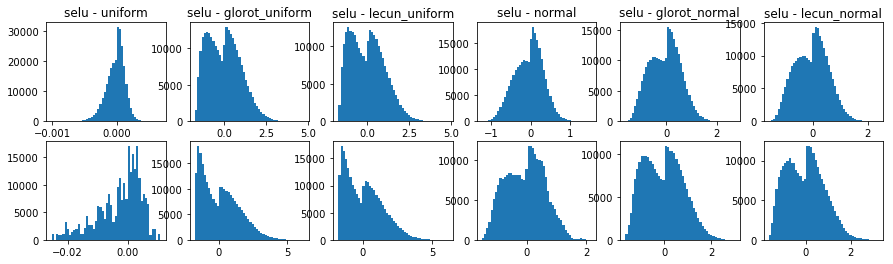

In [7]:
pylab.rcParams['figure.figsize'] = (15, 4)
activations = ['selu']*6
initializers = ['uniform', 'glorot_uniform', 'lecun_uniform', 'normal', 'glorot_normal', 'lecun_normal']
show_model(activations, initializers)

---

### Travail perso
##### Self normalizing Exponential Unit (SExU)

tanh_perso glorot_uniform std: 0.8899, mean: -0.002, acc: 0.996
tanh_perso lecun_uniform std: 0.8901, mean: 0.001, acc: 1.0
tanh_perso glorot_normal std: 0.7282, mean: -0.001, acc: 0.999
tanh_perso lecun_normal std: 0.7411, mean: -0.001, acc: 0.994

Took and average of 28.6 sec. to perfom training


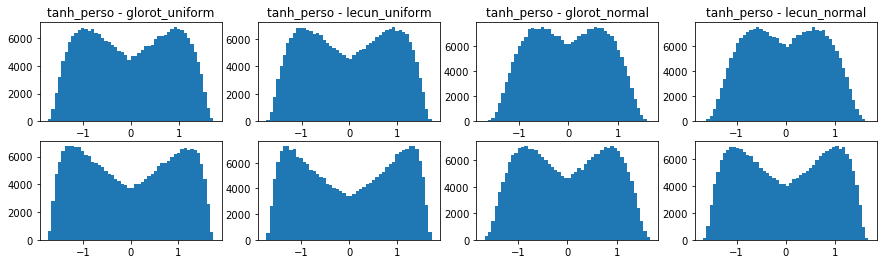

In [8]:
pylab.rcParams['figure.figsize'] = (15, 4)
activations = [keras.activations.tanh_perso]*4
initializers = ['glorot_uniform', 'lecun_uniform', 'glorot_normal', 'lecun_normal']
show_model(activations, initializers)

##### Self normalizing Shifted Exponential Unit (SSExU)
The weights should be shifted by $\alpha$ to converge

sig_perso glorot_uniform std: 0.1129, mean: 0.326, acc: 0.53
sig_perso lecun_uniform std: 0.1134, mean: 0.324, acc: 0.53
sig_perso glorot_normal std: 0.0899, mean: 0.312, acc: 0.53
sig_perso lecun_normal std: 0.0872, mean: 0.315, acc: 0.53

Took and average of 32.6 sec. to perfom training


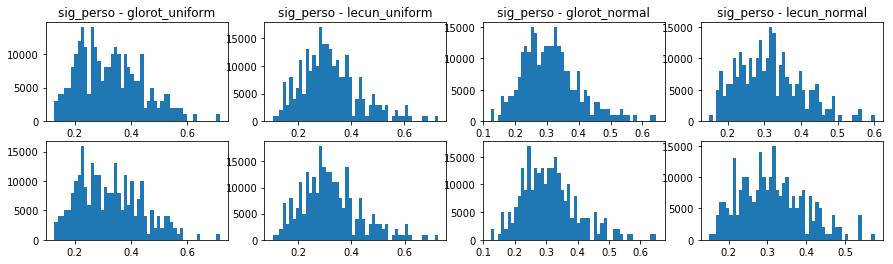

In [9]:
pylab.rcParams['figure.figsize'] = (15, 4)
activations = [keras.activations.sig_perso]*4
initializers = ['glorot_uniform', 'lecun_uniform', 'glorot_normal', 'lecun_normal']
show_model(activations, initializers)

#####  Self normalizing Gated Exponential Neural Network (SGENN)

gated_tanh_perso uniform std: 0.0003, mean: 0.000, acc: 0.53
gated_tanh_perso glorot_uniform std: 0.8159, mean: -0.010, acc: 0.997
gated_tanh_perso lecun_uniform std: 0.8195, mean: -0.002, acc: 0.987
gated_tanh_perso normal std: 0.3972, mean: 0.002, acc: 0.998
gated_tanh_perso glorot_normal std: 0.5852, mean: -0.006, acc: 1.0
gated_tanh_perso lecun_normal std: 0.5914, mean: -0.008, acc: 1.0

Took and average of 1.16e+02 sec. to perfom training


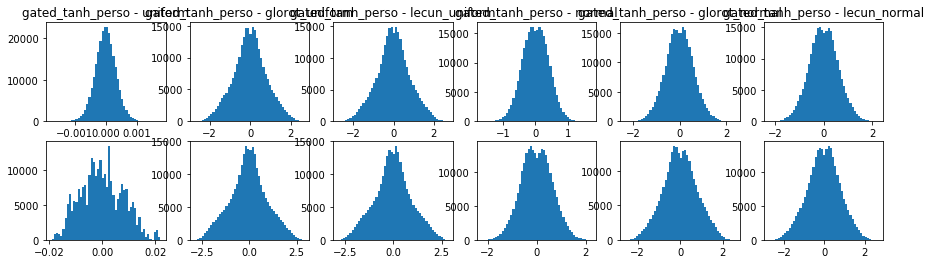

In [10]:
def gated_activation(n_units, activation=None, initializer=None):

    def func(x):
        alpha = 1.7580993408473768599402175208123
        normalizer = np.sqrt(1 + alpha ** 2)
        gate = Dense(n_units,
                     activation='linear',
                     kernel_initializer=initializer)(x)
        gate = Lambda(lambda x: x + alpha)(gate)
        gate = keras.layers.Activation(sig_perso)(gate)

        act = Dense(n_units,
                    activation=activation,
                    kernel_initializer=initializer)(x)
        gated_act = multiply([gate, act])
        gated_act = Lambda(lambda x: x / normalizer)(gated_act)
        return gated_act
    return func


def simple_gated_model(activation, initializer):
    # Define input tensor
    input_tensor = Input(shape=(100,))
    
    # Propagate it through 20 fully connected layers
    x = gated_activation(256, activation, initializer)(input_tensor)
    for _ in range(19):
        x = gated_activation(256, activation, initializer)(x)
    
    x = Dense(1,
              activation='sigmoid',
              kernel_initializer='lecun_normal')(x)
    
    # Build the keras model    
    model = Model(input_tensor, x, name='')
    sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd, loss='binary_crossentropy')

    return model

pylab.rcParams['figure.figsize'] = (15, 4)
activations = [tanh_perso]*6
initializers = ['uniform', 'glorot_uniform', 'lecun_uniform', 'normal', 'glorot_normal', 'lecun_normal']

show_model(activations, initializers, func_model=simple_gated_model)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import keras.backend as K
from keras.layers import Input, Dense, multiply, Lambda, Dense_gated
from keras.models import Model
from keras.activations import tanh_perso, sig_perso
from keras.initializers import VarianceScaling
import shutil
import time
import os

# Create random train data
X_train = np.random.normal(size=(1000, 100))
Y_train = (X_train.sum(axis=1) > 0) * 1

print Y_train.mean()
print X_train.shape
print Y_train.shape

# Normalize it
X_train -= X_train.mean()
X_train /= X_train.std()

# Define input tensor
input_tensor = Input(shape=(100,))

my_dense_layer = lambda : Dense_gated(256,
                                      activation1=tanh_perso,
                                      kernel_initializer1='lecun_uniform',
                                      activation2=tanh_perso,
                                      kernel_initializer2='lecun_uniform',
                                      shift=1.75809934084737685994,
                                      normalizer=np.sqrt(1 + 1.75809934084737685994 ** 2) )

# Propagate it through 20 fully connected layers
x = my_dense_layer()(input_tensor)
for _ in range(30):
    x = my_dense_layer()(x)

x = Dense(1,
          activation='sigmoid',
          kernel_initializer='lecun_normal')(x)

# Build the keras model    
model = Model(input_tensor, x, name='')
sgd = keras.optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['acc'])

model.fit(X_train,
          Y_train,
          validation_data=(X_train, Y_train),
          epochs=10,
          batch_size=128,
          verbose=True )
